In [ ]:
import tensorflow as tf
from tensorflow import keras

import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
img_height = 299
img_width = 299

In [ ]:
!unzip "/content/drive/MyDrive/Clean_Classes.zip"

In [ ]:
data_dir = "/content/drive/MyDrive/Clean_Classes"
data_directory = pathlib.Path(data_dir)

In [ ]:
colonial_count = len(list(data_directory.glob('Colonial Streetlights/*.jpg')))
enclosed_count = len(list(data_directory.glob('Enclosed Streetlights/*.jpg')))
non_count = len(list(data_directory.glob('Non-Streetlights/*.jpg')))
open_count = len(list(data_directory.glob('Open Streetlights/*.jpg')))
total_count = colonial_count + enclosed_count + non_count + open_count
print("There are {} images of Colonial Streetlights".format(colonial_count))
print("There are {} images of Enclosed Streetlights".format(enclosed_count))
print("There are {} images of Non-Streetlights".format(non_count))
print("There are {} images of Open Streetlights".format(open_count))
print("There are {} total images".format(total_count))

There are 411 images of Colonial Streetlights
There are 1035 images of Enclosed Streetlights
There are 471 images of Non-Streetlights
There are 90 images of Open Streetlights
There are 2007 total images


In [ ]:
list_ds = tf.data.Dataset.list_files(str("/content/drive/MyDrive/Clean_Classes/*/*"))
list_ds = list_ds.shuffle(total_count, reshuffle_each_iteration=False)

class_names = np.array(sorted([item.name for item in data_directory.glob('*') ]))
print(class_names)

['Colonial Streetlights' 'Enclosed Streetlights' 'Non-Streetlights'
 'Open Streetlights']


In [ ]:
for f in list_ds.take(5):
  print(f.numpy())

b'/content/drive/MyDrive/Clean_Classes/Non-Streetlights/Image-163-30.jpg'
b'/content/drive/MyDrive/Clean_Classes/Non-Streetlights/Image-82-30.jpg'
b'/content/drive/MyDrive/Clean_Classes/Enclosed Streetlights/Image-2673-30.jpg'
b'/content/drive/MyDrive/Clean_Classes/Enclosed Streetlights/Image-2791-30.jpg'
b'/content/drive/MyDrive/Clean_Classes/Non-Streetlights/Image-554-30.jpg'


In [ ]:
train_size = int(0.7 * total_count)
val_size = int(0.15 * total_count)
test_size = int(0.15 * total_count)


list_ds= list_ds.shuffle(50)
train_dataset = list_ds.take(train_size)
test_dataset = list_ds.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

In [ ]:
print("Training set images: ", tf.data.experimental.cardinality(train_dataset).numpy())
print("Validation set images: ", tf.data.experimental.cardinality(val_dataset).numpy())
print("Test set images: ", tf.data.experimental.cardinality(test_dataset).numpy())

Training set images:  1404
Validation set images:  302
Test set images:  301


In [ ]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [ ]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [ ]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_dataset.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_dataset.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_dataset.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (299, 299, 3)
Label:  2


In [ ]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_set = configure_for_performance(train_ds)
valid_set = configure_for_performance(val_ds)
test_set = configure_for_performance(test_ds)

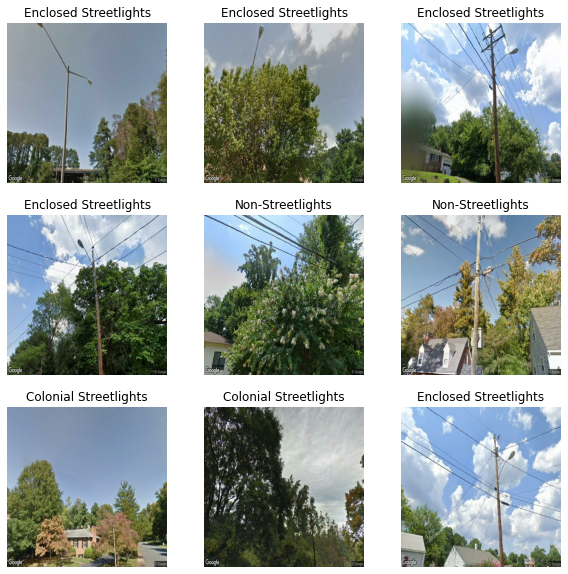

In [ ]:
image_batch, label_batch = next(iter(train_set))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [ ]:
from tensorflow.keras import layers
normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_set.map(lambda x, y: (normalization_layer(x), y))
validation_ds = valid_set.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_set.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
def preprocess(image, label):
    image = tf.keras.applications.inception_resnet_v2.preprocess_input(image)
    return image, label

In [ ]:
def data_augmentation(image, label):
    image = tf.image.random_flip_left_right(image) 
    return image, label

In [ ]:
train_ds = train_ds.shuffle(500).repeat(10) 
train_ds = train_ds.map(data_augmentation)
train_ds = train_ds.map(preprocess)
valid_ds = validation_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

## Two Layer Model


In [ ]:
## State Variables 
n_classes=4
dataset_size=total_count

base_model2 = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet")

base_model2.trainable = False

avg2 = keras.layers.GlobalAveragePooling2D()(base_model2.output)
dense1 = keras.layers.Dense(64, activation="relu")(avg2)
drop1 = keras.layers.Dropout(.25, seed=42)
dense2 = keras.layers.Dense(32, activation="relu")(dense1)
output2 = keras.layers.Dense(n_classes, activation="softmax")(dense2)
model2 = keras.models.Model(inputs=base_model2.input, outputs=output2)

219062272/219055592 [==============================] - 1s 0us/step


In [ ]:
for index, layer in enumerate(base_model2.layers):
    print(index, layer.name)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
early_stopping = EarlyStopping(monitor ='val_accuracy',
                               patience = 10,
                               verbose = 1,
                               mode = 'max',
                               baseline = None,
                               restore_best_weights = True)

In [ ]:
#Run Base Model 

optimizer = keras.optimizers.Adam(learning_rate=0.005)

model2.compile(loss="sparse_categorical_crossentropy", 
               optimizer=optimizer, metrics=["accuracy"])

history = model2.fit(train_ds, 
                     epochs=5, validation_data=valid_ds, callbacks = [early_stopping])

Epoch 1/5
440/440 [==============================] - 360s 391ms/step - loss: 1.1463 - accuracy: 0.5235 - val_loss: 1.1624 - val_accuracy: 0.4901
Epoch 2/5
440/440 [==============================] - 159s 356ms/step - loss: 1.1228 - accuracy: 0.5272 - val_loss: 1.1372 - val_accuracy: 0.4901
Epoch 3/5
440/440 [==============================] - 158s 355ms/step - loss: 1.0776 - accuracy: 0.5437 - val_loss: 1.1005 - val_accuracy: 0.5199
Epoch 4/5
440/440 [==============================] - 160s 359ms/step - loss: 1.0429 - accuracy: 0.5664 - val_loss: 1.0717 - val_accuracy: 0.5298
Epoch 5/5
440/440 [==============================] - 160s 360ms/step - loss: 1.0413 - accuracy: 0.5668 - val_loss: 1.0656 - val_accuracy: 0.5430


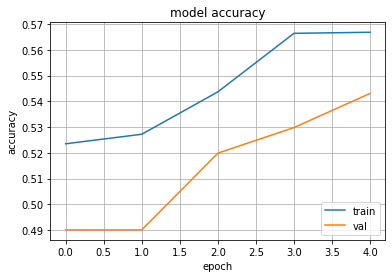

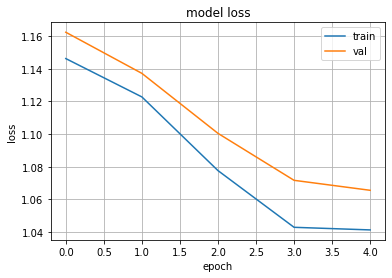

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.grid(True)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.grid(True)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor ='val_accuracy',
                               patience = 10,
                               verbose = 1,
                               mode = 'max',
                               baseline = None,
                               restore_best_weights = True)

optimizer = keras.optimizers.Adam(learning_rate=0.00001)

base_model2.trainable = True

model2.compile(optimizer=optimizer, 
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history3 = model2.fit(train_ds, 
                     validation_data=valid_ds,
                     epochs=10, callbacks = [early_stopping])

Epoch 1/10
440/440 [==============================] - 517s 1s/step - loss: 0.6542 - accuracy: 0.7423 - val_loss: 0.6961 - val_accuracy: 0.7152
Epoch 2/10
440/440 [==============================] - 491s 1s/step - loss: 0.2201 - accuracy: 0.9431 - val_loss: 0.1888 - val_accuracy: 0.9536
Epoch 3/10
440/440 [==============================] - 491s 1s/step - loss: 0.0820 - accuracy: 0.9804 - val_loss: 0.2047 - val_accuracy: 0.9371
Epoch 4/10
440/440 [==============================] - 491s 1s/step - loss: 0.0297 - accuracy: 0.9942 - val_loss: 0.1470 - val_accuracy: 0.9570
Epoch 5/10
440/440 [==============================] - 491s 1s/step - loss: 0.0146 - accuracy: 0.9976 - val_loss: 0.1188 - val_accuracy: 0.9669
Epoch 6/10
440/440 [==============================] - 490s 1s/step - loss: 0.0103 - accuracy: 0.9981 - val_loss: 0.1328 - val_accuracy: 0.9669
Epoch 7/10
440/440 [==============================] - 491s 1s/step - loss: 0.0071 - accuracy: 0.9989 - val_loss: 0.1105 - val_accuracy: 0.9768

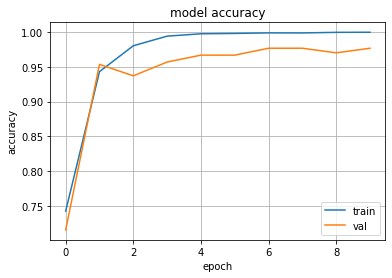

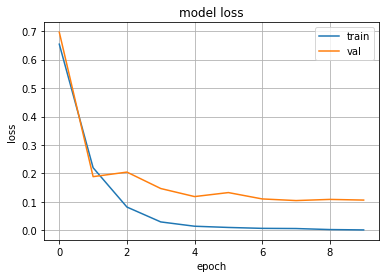

In [ ]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.grid(True)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.grid(True)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Test Set with n=301

In [ ]:
print('Evaluating')
test_loss, test_acc = model2.evaluate(test_ds)
print('\nTest accuracy:', test_acc)

Evaluating
10/10 [==============================] - 18s 488ms/step - loss: 0.2086 - accuracy: 0.9402

Test accuracy: 0.9401993155479431


In [ ]:
class_names

array(['Colonial Streetlights', 'Enclosed Streetlights',
       'Non-Streetlights', 'Open Streetlights'], dtype='<U21')

In [ ]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
  predictions = np.concatenate([predictions, np.argmax(model2.predict(x), axis=1)])
  labels = np.concatenate([labels, y.numpy()])

confusion_matrix = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
confusion_matrix

array([[ 62,   0,   0,   0],
       [  0, 149,   2,   2],
       [  4,   7,  65,   2],
       [  0,   0,   1,   7]], dtype=int32)

In [ ]:
#Save Model
model2.save('streetlight_modelV2.2.h5')